In [3]:
import pandas as pd
import numpy as np
from tqdm import trange

import sys
import glob
import os

from bokeh.core.properties import value
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, DataRange1d, Legend
from bokeh.palettes import brewer
output_notebook()

Loading BokehJS ...

In [4]:
def headlines(search_directories = [''], filename_filter = "*"):

    # Get a list of matching files
    files = []

    for i in range(len(search_directories)):
        files.append(sorted(glob.glob(os.path.join(search_directories[i], filename_filter))))

    files = [item for items in files for item in items] # shorthand to flatten the list of lists

    # Read in files and concatenate
    data = []

    for i in trange(len(files)):
        new_frame = pd.read_csv(files[i], header=0, parse_dates=['publishedAt'])
        new_frame.columns = new_frame.columns.str.replace(".", "_")
        data.append(new_frame)

    return pd.concat(data, sort=False)

In [5]:
!ls ../datastore/processed/

abc-news	  cnn	    msnbc     the-new-york-times
associated-press  fox-news  nbc-news  the-washington-post


In [6]:
data = headlines(
    ['../datastore/processed/abc-news/',
     '../datastore/processed/associated-press/',
    '../datastore/processed/fox-news/',
    '../datastore/processed/msnbc/',
    '../datastore/processed/nbc-news/',
    '../datastore/processed/the-new-york-times/',
    '../datastore/processed/the-washington-post/'],
    '*-2020-*-*')

data = data.set_index('publishedAt', drop=True)
data = data.drop_duplicates()

100%|██████████| 1591/1591 [00:05<00:00, 266.12it/s]


In [7]:
len(data)

246241

In [8]:
def subset_by_text(_data, includes=None, excludes=None, search_field="title"):
    """Count the number of occurrences of text in a dataframe column.
    
    Arguments:
        includes (list): a list of strings for which to search. Each string is searched
        via regex and the result is subsetted in the order they are provided.
        
        excludes (list): a list of strings to exclude. These are executed after the includes
        list, in the order they are provided, and are exclusive. E.g., to keep occurrences
        that have both a word in the includes and in the excludes, you need to devise a
        a single regex-style string and provide it via the includes list.
        
        sources (list): list of elements from source_id to include.
        
        frequency (string): passed to pandas.DataFrame.resample
        
        search_field (string): the column name to search
        
    Returns:
        (pd.DataFrame): a new dataframe containing the counts of results from each source.
    """
    if includes is not None:
        for include_word in includes:
            result = _data[_data[search_field].str.contains(include_word, case=False, na=False)].copy()
        description_text = "Result includes " + ", ".join('"' + include + '"' for include in includes)
        
    else:
        return

    if excludes is not None:
        for exclude_word in excludes:
            result = result[~result[search_field].str.contains(exclude_word, case=False, na=False)]
        
        description_text = description_text + " and excludes " + ", ".join('"' + exclude + '"' for exclude in excludes)

    result.desc = description_text
            
    return result

In [9]:
def count_by_source(_data, freq="D"):
    """Count the number of rows attribtued to each source_name."""
    
    grouper = _data.groupby([pd.Grouper(freq=freq), 'source_id'])
    time_group = grouper['title'].count().unstack('source_id').fillna(0)
    
    time_group.desc = _data.desc
    time_group.freq = freq
    
    return time_group

In [10]:
# retrieved on 2020.09.04 from https://www.adfontesmedia.com/interactive-media-bias-chart-2/
media_config = {
    "fox-news": {"label": "Fox News", "media_bias":22.23, "reliability":26.07, "color": "#E97452"},
    "associated-press": {"label": "Associated Press", "media_bias":-1.20, "reliability":53.71, "color": "#D3CECC"},
    "abc-news": {"label": "ABC News", "media_bias":-3.64, "reliability":49.45, "color": "#b6C7D5"},
    "the-washington-post": {"label": "The Washington Post", "media_bias":-6.13, "reliability":45.49,"color": "#87CEFB"},
    "the-new-york-times": {"label": "New York Times", "media_bias":-7.07, "reliability":47.49, "color": "#659BDF"},
    "nbc-news": {"label": "NBC News", "media_bias":-17.17, "reliability":38.15, "color": "#2234A8"},
    "msnbc": {"label": "MSNBC", "media_bias":-17.17, "reliability":38.15, "color": "#00008C"}
}
media_df = pd.DataFrame(media_config).transpose()

In [11]:
def bokeh_bar(_counts):
    
    bar_width_config = {
        "M":2000000000,
        "W":500000000,
        "D":50000000
    }
    
    print_time_config = {
        "M":"%B %Y",
        "W":"Week of %B %d, %Y",
        "D":"%B %d, %Y"
    }
    
    to_plot = _counts.copy()
    to_plot['showtime'] = to_plot.index.strftime(print_time_config[_counts.freq])

    source = ColumnDataSource(to_plot)

    categories = media_df.index
    labels = media_df['label'].to_list()
    
    tooltips = [
        ('Period', '@showtime'),
        ('Source', '$name'),
        ('Count', '@$name')
    ]
    tools = "xpan, xwheel_zoom, reset"

    p = figure(plot_width=900, plot_height=500, x_axis_type='datetime',
               tooltips = tooltips, tools=tools, y_range=DataRange1d(start=0),
               title=counts.desc)

    v = p.vbar_stack(categories, x='publishedAt', color=media_df['color'].to_list(),
                 width=bar_width_config[_counts.freq], source=source)

    legend = Legend(items=[(x, [v[i]]) for i, x in enumerate(labels)], location=(5, 100))
    p.add_layout(legend)
    p.legend[0].items.reverse()
    p.legend.location = "top_left"
    p.legend.border_line_color = None
    
    show(p)

In [71]:
subset = subset_by_text(data, includes=["virus|pandemic"])
counts = count_by_source(subset, freq="W")
bokeh_bar(counts)

In [75]:
subset = subset_by_text(data, includes=["BLM|Black Lives Matter"])
counts = count_by_source(subset, freq="D")
bokeh_bar(counts)

In [74]:
subset = subset_by_text(data, includes=["Kamala|Harris"], excludes=["Harrison", "Harris Falkner", "Colton Harris"])
counts = count_by_source(subset, freq="D")
bokeh_bar(counts)

In [15]:
subset = subset_by_text(data, includes=["Belarus"])
counts = count_by_source(subset, freq="D")
bokeh_bar(counts)

# Rips

In [86]:
subset = subset_by_text(data, includes=["rip|rips"],
                        excludes=["strip", 'grip', 'trip', 'scrip', 'crip', 'Ripa', 'ripp', 'ripe', 'Rip Van Winkle', 'drip', 'krip'])
counts = count_by_source(subset, freq="W")
bokeh_bar(counts)

In [63]:
def print_headlines(_df, limit=None):
    print(len(_df), "headlines")
    print("=============")
    
    if not limit:
        limit = len(_df)
    
    for i in range(limit):
        print(i, '-', _df.iloc[i].name.strftime("%b %d, %Y"), "-", _df.iloc[i].title)

In [64]:
print_headlines(subset[subset["source_id"] == "the-new-york-times"])

8 headlines
0 - Feb 05, 2020 - Nancy Pelosi (Literally) Rips Trump’s Speech Apart
1 - Apr 07, 2020 - Powerful Cyclone Rips Through Vanuatu, Cutting Communications
2 - Apr 09, 2020 - Checkpoints, Curfews, Airlifts: Virus Rips Through Navajo Nation
3 - Jun 01, 2020 - After Reality Star’s Death, Japan Vows to Rip the Mask Off Online Hate
4 - Jun 04, 2020 - Coronavirus Rips Into Regions Previously Spared
5 - Aug 11, 2020 - Unusual ‘Derecho’ Storms Rip Through Midwest
6 - Aug 21, 2020 - A Rip in the Fabric of Interstellar Dreams
7 - Aug 26, 2020 - Flash Floods Rip Through Afghan City


In [70]:
print_headlines(subset[subset["source_id"] == "msnbc"])

8 headlines
0 - Feb 07, 2020 - Trump: It was 'very illegal' for Pelosi to rip his State of the Union speech: 'She broke the law'
1 - Apr 29, 2020 - Mark Cuban rips 'unprepared' Trump's virus response, suggests new 2020 rival possible
2 - Apr 30, 2020 - Rep. Raskin: House cmte. will prevent people from 'trying to rip off the system'
3 - May 30, 2020 - Demings rips Trump for failure to rise to help nation in crisis
4 - Jun 18, 2020 - Schiff rips Barr for using DOJ to protect Trump from Bolton book
5 - Jul 21, 2020 - ‘Trump has put his head in the sand’: Schumer rips U.S....
6 - Jul 28, 2020 - Bernie rips GOP coronavirus relief proposal: ‘Pathetic would be too mild a word’
7 - Aug 21, 2020 - Clinton rips Trump admin's failure to stand up for American...


In [65]:
print_headlines(subset[subset["source_id"] == "fox-news"], limit=10)

335 headlines
0 - Jan 01, 2020 - Campos-Duffy rips Biden for 'patronizing' remarks on coal miners: This is his 'deplorable' moment
1 - Jan 02, 2020 - Gang of motorcycle thieves rip door off garage to steal bike as security camera rolls
2 - Jan 02, 2020 - Michigan 'swing voters' rip Pelosi and Democrats over impeachment push
3 - Jan 02, 2020 - Busy Philipps goes on epic rant over E! show cancellation, 11-year-old daughter rips network, too
4 - Jan 02, 2020 - Varney rips de Blasio over criticism of Domino's $30 pizzas: 'The man is a socialist'
5 - Jan 03, 2020 - Howard Kurtz rips 'outrageous' NYT tweet about 'Iraqi mourners' storming Baghdad embassy
6 - Jan 03, 2020 - Sanders rips Biden's record as 'so weak' it won't create 'excitement and energy' to defeat Trump
7 - Jan 03, 2020 - CNN military analyst rips Senate Democrat's criticism of Soleimani strike: 'Just be quiet'
8 - Jan 03, 2020 - Tulsi Gabbard rips Soleimani strike: Trump isn't acting like he wants to end 'forever wars'
9 - Jan

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import multidict as multidict
import re
from PIL import Image
import io

In [81]:
def title_wordcloud(df, title=""):
    
    text = df['title'].str.cat(sep=' ')

    stopwords = WordCloud().stopwords.copy()
    other_stop_words = ["US", "say", "says","said", "new", "amid", "former", "will"]
    for word in other_stop_words:
        stopwords.add(word)
    
    mask = np.ones((400, 400), dtype=np.int8)
    wc = WordCloud(background_color="white", max_words=1000, mask=mask, collocations=False, stopwords=stopwords)
    
    # generate word cloud
    wc.generate_from_text(text)

    # Figure
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title, fontsize=24, fontweight="bold", pad=10)
    
    ## save figure
    buf = io.BytesIO()
    
    fig.savefig(
        buf,
        format='png',
        bbox_inches='tight',
        pad_inches=0.0
    )
    
    plt.close(fig)
    
    return Image.open(buf)

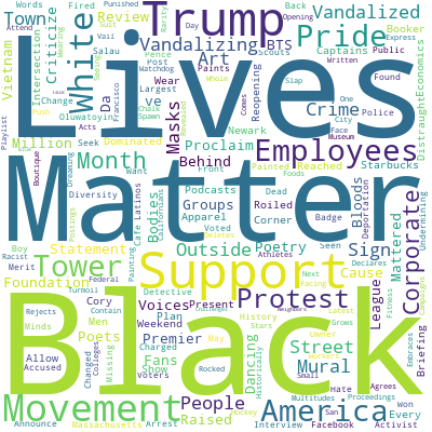

In [82]:
title_wordcloud(subset[subset["source_id"] == "the-new-york-times"])

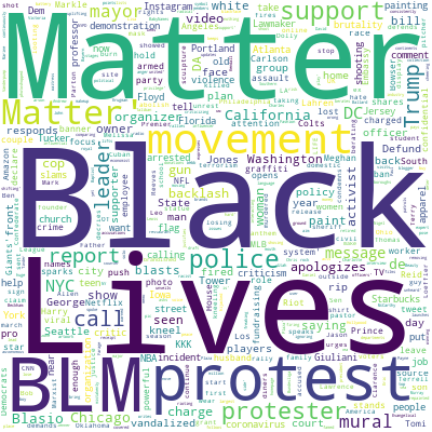

In [83]:
title_wordcloud(subset[subset["source_id"] == "fox-news"])

In [87]:
subset = subset_by_text(data, includes=["qanon"])
counts = count_by_source(subset, freq="W")
bokeh_bar(counts)

In [90]:
print_headlines(subset[subset["source_id"] == "fox-news"])

12 headlines
0 - Jun 15, 2020 - QAnon conspiracy theory enters politics: What to know
1 - Jun 25, 2020 - UFC launches investigation after cut man seen wearing QAnon symbols during fight
2 - Aug 13, 2020 - QAnon hijacks #savethechildren hashtag: report
3 - Aug 14, 2020 - Marjorie Greene, controversial Georgia Republican, says she's not a QAnon candidate
4 - Aug 19, 2020 - Trump addresses QAnon conspiracy theory for the first time: 'I heard that these are people that love our country'
5 - Aug 20, 2020 - Karl Rove condemns QAnon as 'a group of nuts and kooks,' says Trump 'ought to disavow them'
6 - Aug 20, 2020 - McEnany says Trump does not support QAnon following president's first comment about conspiracy group
7 - Aug 20, 2020 - Trump praises supporters of QAnon conspiracy theory
8 - Aug 21, 2020 - House GOP leader McCarthy disavows QAnon, calls on Dems to speak out against anti-Semitism
9 - Aug 23, 2020 - Dem senator calls on Trump to denounce QAnon conspiracy theory
10 - Aug 26, 2020 